![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/4bd64c1deb3c4ffb8ca7ff93c1f1497d).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:

# Importación librerías

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option("display.max_columns", None)

#from pickle5 import pickle
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_selection import f_regression, SelectKBest, mutual_info_regression, mutual_info_classif, RFE, SelectFromModel, SequentialFeatureSelector
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.feature_selection import f_regression, SelectKBest

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn import metrics


from tpot import TPOTRegressor
import hyperopt
from hyperopt import fmin, hp, tpe, Trials, SparkTrials, space_eval, STATUS_OK



import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


In [4]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTest_carListings.zip', index_col=0)

In [9]:
# Visualización datos de entrenamiento
print(dataTraining.shape)
dataTraining.head()

(400000, 6)


,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [10]:
# Visualización datos de test
print(dataTesting.shape)
dataTesting.head()

(100000, 5)


,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


## Analisis Exploratorio

In [11]:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    400000 non-null  int64 
 1   Year     400000 non-null  int64 
 2   Mileage  400000 non-null  int64 
 3   State    400000 non-null  object
 4   Make     400000 non-null  object
 5   Model    400000 non-null  object
dtypes: int64(3), object(3)
memory usage: 18.3+ MB


In [12]:
dataTraining.isnull().sum()

Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

In [13]:
dataTraining.describe()

,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06


In [14]:
numeric_features = dataTraining.select_dtypes(exclude=['category', object]).columns.values 
categorical_features = dataTraining.select_dtypes(include=['category', object]).columns.values

Out[11]:

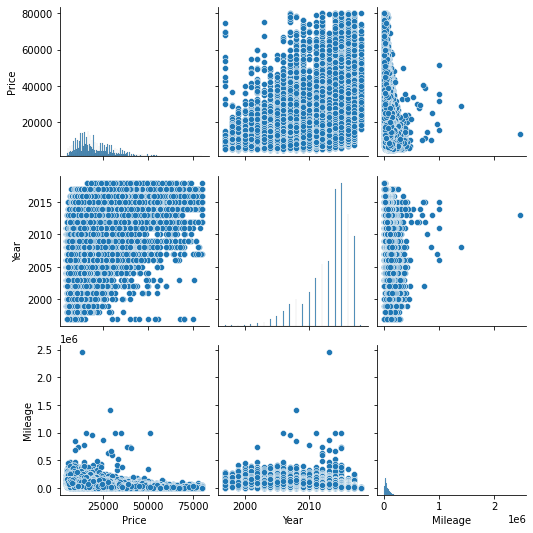

<seaborn.axisgrid.PairGrid at 0x7f80c214c820>

In [0]:
sns.pairplot(dataTraining[numeric_features])

In [15]:
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


Out[13]:

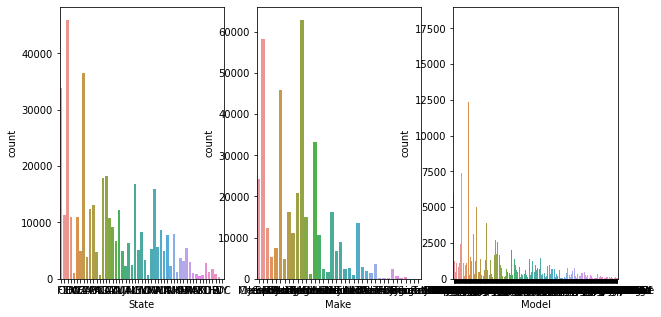

<AxesSubplot:xlabel='Model', ylabel='count'>

In [0]:
fig, axes=plt.subplots(1,3, figsize=(10, 5))
sns.countplot(x = 'State', data = dataTraining, ax=axes[0])
sns.countplot(x = 'Make', data = dataTraining, ax=axes[1])
sns.countplot(x = 'Model', data = dataTraining, ax=axes[2])

## Preprocesamiento de datos

In [5]:
XTotal = dataTraining.drop(columns = ['Price'])
yTotal = dataTraining['Price']

In [6]:
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.33, random_state=0)

In [7]:
# funciones util
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=int)
        X_mask = np.ones_like(X, dtype=bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

# A class to select numerical or categorical columns
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [8]:

categorical_features = ['State', 'Make', 'Model']
numeric_features = ['Year', 'Mileage']

numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(numeric_features)),
])

categorical_pipeline= Pipeline([
    ("select_cat", DataFrameSelector(categorical_features)),
    ("cat_encoder", CategoricalEncoder(encoding='ordinal'))
])

preprocess_pipeline = FeatureUnion(transformer_list=[
    ("numerical_pipeline", numerical_pipeline),             
    ("categorical_pipeline", categorical_pipeline),
])

XTrain_p = preprocess_pipeline.fit_transform(XTrain)

XTest_p = preprocess_pipeline.transform(XTest)

XTrain_enc = pd.DataFrame(XTrain_p, columns=XTrain.columns)
XTest_enc = pd.DataFrame(XTest_p, columns=XTest.columns)

Out[18]:

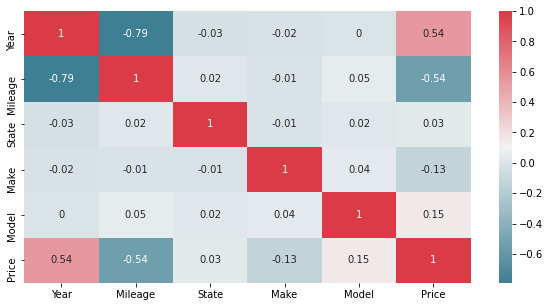

<AxesSubplot:>

In [0]:
train_all_df = pd.concat([XTrain_enc, pd.DataFrame(yTrain).reset_index(drop=True)], axis=1)

correlation_matrix = train_all_df.corr(method='spearman').round(2)
fig,axes = plt.subplots(1,1,figsize=(10,5))
sns.heatmap(data=correlation_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True,ax=axes)

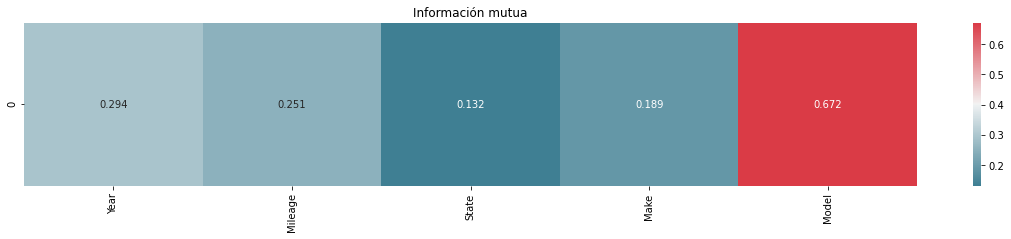

In [0]:
mu_inf = mutual_info_regression(XTrain_enc, yTrain, discrete_features=False)

fig, ax = plt.subplots(1,1, figsize=(20,3))
ax.set_title('Información mutua')
sns.heatmap([mu_inf],ax=ax,cmap=sns.diverging_palette(220,10,as_cmap=True), annot=True,fmt=".3f")
ax.set_xticklabels(XTrain.columns.to_list())
ax.tick_params(axis='x', rotation=90)

## Calibración del modelo

In [20]:
XTrain_sample, _, yTrain_sample, _ = train_test_split(XTrain_enc, yTrain, train_size=0.90, random_state=0)

In [21]:
XTrain_sample.shape

(241200, 5)

In [0]:
#RANDOM FOREST

# calibracion con RandomizedSearchCV
param = {'max_depth': np.arange(1, 100),
        'n_estimators': np.arange(10, 300),
        'max_features': [1, 2, 3, 4], 
        'min_samples_leaf': [1, 2, 4, 6, 8, 12], 
        'min_samples_split': [2, 5, 7, 10, 14]}


bc_gs = RandomizedSearchCV(RandomForestRegressor(), param, n_iter=100, cv=5, verbose=1, scoring='neg_root_mean_squared_error', n_jobs=10)
bc_gs.fit(XTrain_sample, yTrain_sample)

print("Calibracion de RandomForest")
print(f'Best estimator: {bc_gs.best_estimator_}')

In [0]:
# calibracion con TPOT (algoritmo genetico)
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 300, num = 10)]
max_features = [1, 2, 3, 4, 5]
max_depth = [int(x) for x in np.linspace(2, 100, 20)]
min_samples_split = [2, 5, 10, 14]
min_samples_leaf = [1, 2, 4, 6, 8]

param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


tpot = TPOTRegressor(generations=5, population_size=24, early_stop= 12, verbosity=2, 
                      config_dict={'sklearn.ensemble.RandomForestRegressor': param}, 
                      cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs=5)
tpot.fit(XTrain_sample, yTrain_sample)

Optimization Progress: 0%| | 0/144 [00:00<?, ?pipeline/s]

Generation 1 - Current best internal CV score: -19478191.153723404

Generation 2 - Current best internal CV score: -19463928.967987478

Generation 3 - Current best internal CV score: -19463928.967987478

Generation 4 - Current best internal CV score: -19160635.58932329

Generation 5 - Current best internal CV score: -19129981.2387769

Best pipeline: RandomForestRegressor(input_matrix, max_depth=38, max_features=4, min_samples_leaf=1, min_samples_split=5, n_estimators=180)
Out[17]: TPOTRegressor(config_dict={'sklearn.ensemble.RandomForestRegressor': {'max_depth': [2,
 7,
 12,
 17,
 22,
 27,
 32,
 38,
 43,
 48,
 53,
 58,
 63,
 69,
 74,
 79,
 84,
 89,
 94,
 100],
 'max_features': [1,
 2,
 3,
 4,
 5],
 'min_samples_leaf': [1,
 2,
 4,
 6,
 8],
 'min_samples_split': [2,
 5,
 10,
 14],
 'n_estimators': [30,
 60,
 90,
 120,
 150,
 180,
 210,
 240,
 270,
 300]}},
 early_stop=12, generations=5, n_jobs=5, population_size=24,
 scoring='neg_mean_squared_error', verbosity=2)

In [0]:
## XGBOOST
params = {
    'min_child_weight': [ 1, 3, 5, 7 ],
    'gamma':  np.linspace(0, 30, 200),
    'eta': np.linspace(0, 1, 25),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [ 0.3, 0.4, 0.5 , 0.7 ],
    'max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15],
    'n_estimators': np.arange(10, 300)
}
xg_reg = xgb.XGBRegressor()

random_search = RandomizedSearchCV(xg_reg, param_distributions=params, n_iter=100, scoring='neg_root_mean_squared_error', cv=5, verbose=2, n_jobs=5)

random_search.fit(XTrain_sample, yTrain_sample)

print("Calibracion de XGBoost regressor")
print(f'Best estimator: {random_search.best_estimator_}')
print('\n Best hyperparameters:')
print(random_search.best_params_)


In [0]:
XTrain_sample2, XTest_sample2, yTrain_sample2, yTest_sample2 = train_test_split(XTrain_sample, yTrain_sample, test_size=0.33, random_state=0)

print(XTrain_sample2.shape)
print(XTest_sample2.shape)

(53868, 5)
(26532, 5)

In [23]:
## Hyperopt (Optimizacion Bayesiana)

# RF

def objective(search_space):
    model = RandomForestRegressor(**search_space)
    rmse = -cross_val_score(model, XTrain_enc, yTrain, cv=3, scoring='neg_root_mean_squared_error').mean()

    return {'loss': rmse, 'status': STATUS_OK}


# new search space
search_space={'n_estimators':hp.randint('n_estimators', 50,300),
              'max_depth': hp.randint('max_depth',4, 100),
              'min_samples_split':hp.uniform('min_samples_split',0,1),
              'min_samples_leaf':hp.randint('min_samples_leaf',1, 10),
              'max_features':hp.choice('max_features',[1, 2, 3, 4, 5])
             }

spark_trials = Trials()
# implement Hyperopt
best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=25,
    trials=spark_trials)

space_eval(search_space, best_params)

100%|██████████| 25/25 [13:39<00:00, 32.80s/trial, best loss: 5128.098203998299]


{'max_depth': 59,
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 0.00570937116381259,
 'n_estimators': 164}

100%|██████████| 200/200 [09:12<00:00,  2.76s/trial, best loss: 4587.053219506799]
Out[27]: {'max_depth': 70,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 4.194424016451537e-05,
 'n_estimators': 862}

In [24]:
# XGB

def objective(search_space):
    model = xgb.XGBRegressor(**search_space)
    rmse = -cross_val_score(model, XTrain_enc, yTrain, cv=3, scoring='neg_root_mean_squared_error').mean()
    return {'loss': rmse, 'status': STATUS_OK}

# XGB parameters
xgb_reg_params = {
    'learning_rate': hp.choice('learning_rate',    np.linspace(0, 1, 25)),
    'gamma': hp.choice('gamma', np.linspace(0, 30, 200)),
    'max_depth':        hp.choice('max_depth',        np.arange(3, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.6, 1),
    'n_estimators':    hp.choice('n_estimators', np.arange(10, 300))
}

spark_trials = Trials()
# implement Hyperopt
best_params = fmin(
    fn=objective,
    space=xgb_reg_params,
    algo=tpe.suggest,
    max_evals=100, 
    trials=spark_trials)

space_eval(xgb_reg_params, best_params)

100%|██████████| 100/100 [2:23:53<00:00, 86.34s/trial, best loss: 3485.6058381757525]  


{'colsample_bytree': 0.6000000000000001,
 'gamma': 3.467336683417085,
 'learning_rate': 0.041666666666666664,
 'max_depth': 13,
 'min_child_weight': 4,
 'n_estimators': 262,
 'subsample': 0.773159917960503}

## Entrenamiento del modelo

In [0]:
#XGboost sin calibrar

xgb_regressor = xgb.XGBRegressor(random_state=1, n_jobs=20)
xgb_regressor.fit(XTrain_enc, yTrain)

y_predict = xgb_regressor.predict(XTest_enc)

print("XGBoost Regressor")
print(f'RMSE: {mean_squared_error(yTest, y_predict, squared=False)}')

XGBoost Regressor
MSE: 3700.4343455071476

In [0]:
print(cross_val_score(xgb_regressor, XTrain_enc, yTrain, cv=5, scoring='neg_root_mean_squared_error', n_jobs=20).mean())

-3668.2132876903006

In [0]:
# RF sin calibrar
clf = RandomForestRegressor(random_state=1, n_jobs=5)
clf.fit(XTrain_enc, yTrain)

y_predict = clf.predict(XTest_enc)

print("RandomForest Regressor")
print(f'RMSE: {mean_squared_error(yTest, y_predict, squared=False)}')

RandomForest Regressor
RMSE: 3808.0782097420347

In [0]:
print(cross_val_score(clf, XTrain_enc, yTrain, cv=5, scoring='neg_root_mean_squared_error', n_jobs=5).mean())

-3783.381369652458

In [0]:
# RF calibrado
#clf = RandomForestRegressor(max_depth=18, max_features=4, n_estimators=180, n_jobs=20)

#clf = RandomForestRegressor(max_depth=64, max_features=4, min_samples_leaf=4,
#                      min_samples_split=10, n_estimators=221, n_jobs=5)

#clf = RandomForestRegressor(max_depth=44, max_features=5, min_samples_leaf=4,
#                      min_samples_split=10, n_estimators=156, n_jobs=5)

#clf = RandomForestRegressor(max_depth=32, max_features=5, min_samples_leaf=4,
#                      min_samples_split=5, n_estimators=266, n_jobs=20)

clf = RandomForestRegressor(max_depth=75, max_features=4, n_estimators=254, n_jobs=10)

clf.fit(XTrain_enc, yTrain)

y_predict = clf.predict(XTest_enc)

print("RandomForest Regressor")
print(f'RMSE: {mean_squared_error(yTest, y_predict, squared=False)}')

RandomForest Regressor
RMSE: 3779.2778283941766

In [0]:
print(cross_val_score(clf, XTrain_enc, yTrain, cv=5, scoring='neg_root_mean_squared_error', n_jobs=20).mean())

In [0]:
xgb_regressor = xgb.XGBRegressor(, n_jobs=5)
xgb_regressor.fit(XTrain_enc, yTrain)

y_predict = xgb_regressor.predict(XTest_enc)

print("XGBoost Regressor")
print(f'RMSE: {mean_squared_error(yTest, y_predict, squared=False)}')

### Complete Pipeline

In [9]:
# preprocessor
categorical_features = ['State', 'Make', 'Model']
numeric_features = ['Year', 'Mileage']

numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(numeric_features)),
])

categorical_pipeline= Pipeline([
    ("select_cat", DataFrameSelector(categorical_features)),
    ("cat_encoder", CategoricalEncoder(encoding='ordinal'))
])

preprocess_pipeline = FeatureUnion(transformer_list=[
    ("numerical_pipeline", numerical_pipeline),             
    ("categorical_pipeline", categorical_pipeline),
])


# model
# {'learning_rate': 0.04660442516384383, 'gamma': 25.69025797151704, 'max_depth': 12, 'min_child_weight': 6, 'colsample_bytree': 0.6000000000000001, 'subsample': 0.9911830515002495, 'n_estimators': 277}

xgb_reg = xgb.XGBRegressor(colsample_bytree=0.6000000000000001,gamma=25.69025797151704,
                                 learning_rate=0.04660442516384383,max_depth=12,min_child_weight=6,n_estimators=277, subsample=0.9911830515002495,n_jobs=1)

pipeline = Pipeline(steps = [
               ('preprocessor', preprocess_pipeline)
              ,('regressor',xgb_reg)
])


from sklearn import set_config
set_config(display="diagram")
pipeline

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('numerical_pipeline',
                                                 Pipeline(steps=[('select_numeric',
                                                                  DataFrameSelector(attribute_names=['Year',
                                                                                                     'Mileage']))])),
                                                ('categorical_pipeline',
                                                 Pipeline(steps=[('select_cat',
                                                                  DataFrameSelector(attribute_names=['State',
                                                                                                     'Make',
                                                                                                     'Model'])),
                                                                 ('cat_encoder',
                                                                  CategoricalEncoder(encoding='ordinal'))]))]...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.04660442516384383, max_bin=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=12, max_leaves=None, min_child_weight=6,
                              missing=nan, monotone_constraints=None,
                              n_estimators=277, n_jobs=1,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, reg_alpha=None,
                              reg_lambda=None, ...))])

In [10]:
model = pipeline.fit(XTrain, yTrain)
print(model)

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('numerical_pipeline',
                                                 Pipeline(steps=[('select_numeric',
                                                                  DataFrameSelector(attribute_names=['Year',
                                                                                                     'Mileage']))])),
                                                ('categorical_pipeline',
                                                 Pipeline(steps=[('select_cat',
                                                                  DataFrameSelector(attribute_names=['State',
                                                                                                     'Make',
                                                                                                     'Model'])),
                                                                 ('cat_encoder',
                   

In [11]:
y_predict = pipeline.predict(XTest)

print("RandomForest Regressor")
print(f'MSE: {mean_squared_error(yTest, y_predict, squared=False)}')

RandomForest Regressor
MSE: 3489.280270568571


In [12]:
pipe = pipeline.fit(XTotal, yTotal)
print(pipe)

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('numerical_pipeline',
                                                 Pipeline(steps=[('select_numeric',
                                                                  DataFrameSelector(attribute_names=['Year',
                                                                                                     'Mileage']))])),
                                                ('categorical_pipeline',
                                                 Pipeline(steps=[('select_cat',
                                                                  DataFrameSelector(attribute_names=['State',
                                                                                                     'Make',
                                                                                                     'Model'])),
                                                                 ('cat_encoder',
                   

In [13]:
y_predict = pipe.predict(dataTesting)
y_pred = pd.DataFrame(y_predict, index=dataTesting.index, columns=['Price'])
y_pred.to_csv('xgb_submission_2.csv', index_label='ID')

## Disponibilización del modelo

## Conclusiones

In [0]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 75000 + 5000, index=dataTesting.index, columns=['Price'])

In [0]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission.csv', index_label='ID')
y_pred.head()